In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# !ls gdrive/MyDrive

Mounted at /content/gdrive


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torchvision.models as model
# !pip install torchsummary
from torchsummary import summary
from sklearn.metrics import precision_score, f1_score,recall_score,accuracy_score
from torch.optim.lr_scheduler import StepLR

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(DoubleConv,self).__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,3,1,1,bias = False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True),

        nn.Conv2d(out_channels,out_channels,3,1,1,bias = False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True),
    )

  def forward(self,x):
    return self.conv(x)


In [ ]:
class UNET(nn.Module):
  def __init__(self,in_channels = 3,out_channels = 1,features = [64,128,256,512]):
    super(UNET,self).__init__()
    self.downs = nn.ModuleList()
    self.ups = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size = 2,stride = 2)

    # Down part of UNET
    for feature in features:
      self.downs.append(DoubleConv(in_channels,feature))
      in_channels = feature

    # Up part of UNET
    for feature in reversed(features):
       self.ups.append(nn.ConvTranspose2d(feature*2,feature,kernel_size = 2,stride = 2))
       self.ups.append(DoubleConv(feature*2,feature))

    self.bottleneck = DoubleConv(features[-1],features[-1]*2)
    self.final_conv = nn.Conv2d(features[0],out_channels,kernel_size = 1)


  def forward(self,x):
    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)

    skip_connections = skip_connections[::-1]

    for idx in range(0,len(self.ups),2):
      x = self.ups[idx](x)

      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x,size = skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection,x),dim = 1)
      x = self.ups[idx+1](concat_skip)

    return self.final_conv(x)

def test():
  x = torch.randn((3,3,417,417))
  model = UNET(in_channels=3,out_channels = 1)
  preds = model(x)
  print('------------------------')
  print(x.shape)
  print(preds.shape)
  # assert preds.shape == x.shape

if __name__ == "__main__":
  test()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


------------------------
torch.Size([3, 3, 417, 417])
torch.Size([3, 1, 417, 417])


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
class SlumDataset(Dataset):
  def __init__(self,image_dir,mask_dir,transform = None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)
    self.masks = os.listdir(mask_dir)

  def __len__(self):
    return len(self.masks)

  def __getitem__(self,index):
    img_path = os.path.join(self.image_dir,self.images[index])
    mask_path = os.path.join(self.mask_dir,self.masks[index])

    image = np.array(Image.open(img_path))
    mask = np.array(Image.open(mask_path).convert('L'), dtype = np.float32)
    mask = (mask//246.0)
    image = (image/255.0)


    if self.transform != None:
      augment = self.transform(image = image,mask = mask)
      image = augment['image']
      mask = augment['mask']

      if(image.shape[1:] != mask.shape):
        print("-------------- ---------------------------")
        print("!!!Warning!!!")
        print(image.shape[1:])
        print(mask.shape)

    return image,mask

Just for checking the above code

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader

In [ ]:
def save_checkpoint(state,filename = "my_checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state,filename)

In [ ]:
def load_checkpoint(checkpoint,model,optimizer):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])
  optimizer.load_state_dict(checkpoint["optimizer"])

In [ ]:
def get_loaders(
    train_dir,
    train_mask_dir,
    val_dir,
    val_mask_dir,
    batch_size,
    train_transform,
    val_transform,
    train_val,
    num_workers = 2,
    pin_memory = True,
):

  train_ds = SlumDataset(
      image_dir = train_dir,
      mask_dir = train_mask_dir,
      transform = train_transform
  )

  train_loader = DataLoader(
      train_ds,
      batch_size = batch_size,
      num_workers = num_workers,
      pin_memory = pin_memory,
      shuffle = True,
  )

  val_ds = SlumDataset(
      image_dir = val_dir,
      mask_dir = val_mask_dir,
      transform = val_transform
  )

  val_loader = DataLoader(
      val_ds,
      batch_size = batch_size,
      num_workers = num_workers,
      pin_memory = pin_memory,
      shuffle = False,
  )

  return train_loader, val_loader

In [ ]:
def dice_coefficient(predicted_mask, ground_truth_mask):
  intersection = np.sum(predicted_mask * ground_truth_mask)
  predicted_area = np.sum(predicted_mask)
  ground_truth_area = np.sum(ground_truth_mask)

  dice = (2.0 * intersection) / (predicted_area + ground_truth_area)
  return dice

def check_accuracy(loss_fn,loader,model,accuracy_vals,dice_scores,iou_scores,precision_scores,recall_scores,f1_val,val_loss,device = "cuda"):
  num_correct = 0
  num_pixels = 0
  dice_s = []
  precision_s = []
  f1_s = []
  iou_s = []
  recall_s = []
  accuracy_s = []
  model.eval()

  with torch.no_grad():
    for x,y in loader:
      x = x.to(device)
      y = y.to(device).unsqueeze(1)
      pred = torch.sigmoid(model(x))

      val_loss += loss_fn(y,pred).item()

      pred = (pred > 0.5).float()
      num_correct += (pred == y).sum()
      num_pixels += torch.numel(pred)
      preds = pred.cpu().numpy()
      yy = y.cpu().numpy()


      for pred_mask, gt_mask in zip(preds, yy):
        # Flatten the binary masks for precision calculation
        pred_mask_flat = pred_mask.flatten()
        gt_mask_flat = gt_mask.flatten()

        # Calculate recall score for the current mask
        recall = recall_score(gt_mask_flat, pred_mask_flat)
        recall_s.append(recall)

        # Calculate precision for the current mask
        precision = precision_score(gt_mask_flat, pred_mask_flat)
        precision_s.append(precision)

        # Calculate F1 score for the current mask
        # F1-score is the harmonic mean of Precision and Recall,
        # F1-score = 2 * (Precision * Recall) / (Precision + Recall)

        f1 = f1_score(gt_mask_flat, pred_mask_flat)
        f1_s.append(f1)

        # Calculate the intersection and union of the binary masks
        intersection = np.sum(pred_mask * gt_mask)
        union = np.sum(np.logical_or(pred_mask, gt_mask))

        # Calculate IoU for the current mask
        iou = intersection / union
        iou_s.append(iou)

        # Calculate Accuarcy for the current mask
        accuracy = np.mean(gt_mask_flat == pred_mask_flat)
        accuracy_s.append(accuracy)

        dice_score = dice_coefficient(pred_mask, gt_mask)
        dice_s.append(dice_score)

  val_loss /= len(loader)
  accu = (num_correct/num_pixels)*100
  print(f"Got {num_correct}/{num_pixels} with accuracy {accu}")

  # Calculate the average precision over the validation dataset
  average_precision = np.mean(precision_s)
  print(f"Average Precision: {average_precision:.4f}")

  #Calculate the average accuracy over the validation dataset
  accuracy_vals.append(np.mean(accuracy_s))
  print(f'Accuracy: {np.mean(accuracy_s)}')

  # Calculate the average Dice score over the validation dataset
  average_dice = np.mean(dice_s)
  print(f"Average Dice Score: {average_dice:.4f}")

  # Calculate the average F1 score over the validation dataset
  average_f1 = np.mean(f1_s)
  print(f"Average F1 Score: {average_f1:.4f}")

  # Calculate the average IoU score over the validation dataset
  average_iou = np.mean(iou_s)
  print(f"Average IoU Score: {average_iou:.4f}")

  # Calculate average metrics for the epoch
  iou_scores.append(average_iou)
  precision_scores.append(average_precision)
  recall_scores.append(np.mean(recall_s))
  f1_val.append(average_f1)
  dice_scores.append(average_dice)

  model.train()

In [ ]:
def save_predictions_as_imgs(loader,model,folder="saved_images/",device = "cuda"):
  model.eval()
  for idx, (x,y) in enumerate(loader):
    x = x.to(device = device)

    with torch.no_grad():
      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()
      # preds = (preds > 0.5).astype(torch.int)

    torchvision.utils.save_image(preds,f"{folder}/pred_{idx}.jpg")
    torchvision.utils.save_image(y.unsqueeze(1),f"{folder}/{idx}.jpg")

  model.train()


def my_plot(epochs, loss):
  plt.xlabel("losses")
  plt.ylabel("Num of epochs")
  plt.plot(epochs, loss)

In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from numpy import random

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

# Hyperparameters
LEARNING_RATE = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 2
NUM_WORKERS = 2
train_val = 0.8
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
train_valid = 0.8

PIN_MEMORY = True
LOAD_MODEL = True

TRAIN_IMG_DIR = '/content/gdrive/MyDrive/Summer Project: Slum Prediction Using Deep Learning/Data/new_complete_images/train_img'
TRAIN_MASK_DIR = '/content/gdrive/MyDrive/Summer Project: Slum Prediction Using Deep Learning/Data/new_complete_images/train_mask'
val_dir = '/content/gdrive/MyDrive/Summer Project: Slum Prediction Using Deep Learning/Data/new_complete_images/val_img'
val_mask_dir = '/content/gdrive/MyDrive/Summer Project: Slum Prediction Using Deep Learning/Data/new_complete_images/val_mask'
saved_folder = '/content/gdrive/MyDrive/Summer Project: Slum Prediction Using Deep Learning/Data/new_complete_images/saved_images'

In [ ]:
def train_fn(epoch,num_epochs,loader,model,optimizer,loss_fn,scaler,iou_train,precision_train,recall_train,f1_train,loss_train,accuracy_train):
  total_loss = 0.0
  total_iou = 0.0
  total_precision = 0.0
  total_recall = 0.0
  total_f1 = 0.0
  total_accuracy = 0.0

  length = len(loader);
  loop = tqdm(loader)

  for batch_idx, (data,targets) in enumerate(loop):
    data = data.to(device = device)
    targets = targets.float().unsqueeze(1).to(device = device)
    targ = targets

    # forward
    with torch.cuda.amp.autocast():
      predictions = torch.sigmoid(model(data))

      loss = loss_fn(predictions,targets)
      total_loss += loss.item()

      # convert model outputs to binary mask using sigmoid and threshold
      predicted_masks = predictions
      predicted_masks = (predicted_masks > 0.5).float()

      preds = predicted_masks.cpu().numpy()
      yy = targ.cpu().numpy()

      # Calculate the intersection and union of the binary masks
      intersection = np.sum(preds * yy)
      union = np.sum(np.logical_or(preds, yy))
      iou = intersection / union

      precision = precision_score(yy.flatten(), preds.flatten())
      recall = recall_score(yy.flatten(), preds.flatten())
      f1 = f1_score(yy.flatten(), preds.flatten())
      accuracy = np.mean(yy.flatten() == preds.flatten())

      total_iou += iou
      total_precision += precision
      total_recall += recall
      total_f1 += f1
      total_accuracy += accuracy

    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    loop.set_postfix(loss = loss.item())

  average_loss = total_loss / length
  average_iou = total_iou / length
  average_precision = total_precision / length
  average_recall = total_recall / length
  average_f1 = total_f1 / length
  average_accuracy = accuracy /length

  # Append metrics and losses to lists for plotting
  loss_train.append(average_loss)
  iou_train.append(average_iou)
  precision_train.append(average_precision)
  recall_train.append(average_recall)
  f1_train.append(average_f1)
  accuracy_train.append(average_accuracy)

  print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Loss: {average_loss:.4f}, "
          f"IoU: {average_iou:.4f}, "
          f"Precision: {average_precision:.4f}, "
          f"Recall: {average_recall:.4f}, "
          f"F1: {average_f1:.4f},"
          f"Accuracy: {average_accuracy:4f}"
  )


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 178/178 [24:36<00:00,  8.29s/it, loss=0.735]


Epoch [1/2], Loss: 0.7548, IoU: 0.0881, Precision: 0.4576, Recall: 0.1094, F1: 0.1565,Accuracy: 0.004169
=> Saving checkpoint


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Got 26860069/46530560 with accuracy 57.725650787353516
Average Precision: 0.2637
Accuracy: 0.5772565170073174
Average Dice Score: 0.3043
Average F1 Score: 0.3043
Average IoU Score: 0.1989


100%|██████████| 178/178 [08:05<00:00,  2.73s/it, loss=0.725]


Epoch [2/2], Loss: 0.7262, IoU: 0.0316, Precision: 0.5275, Recall: 0.0326, F1: 0.0606,Accuracy: 0.003863
=> Saving checkpoint


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Got 36868048/46530560 with accuracy 79.23405456542969
Average Precision: 0.0510
Accuracy: 0.792340517715669
Average Dice Score: 0.0142
Average F1 Score: 0.0142
Average IoU Score: 0.0083
Training finished


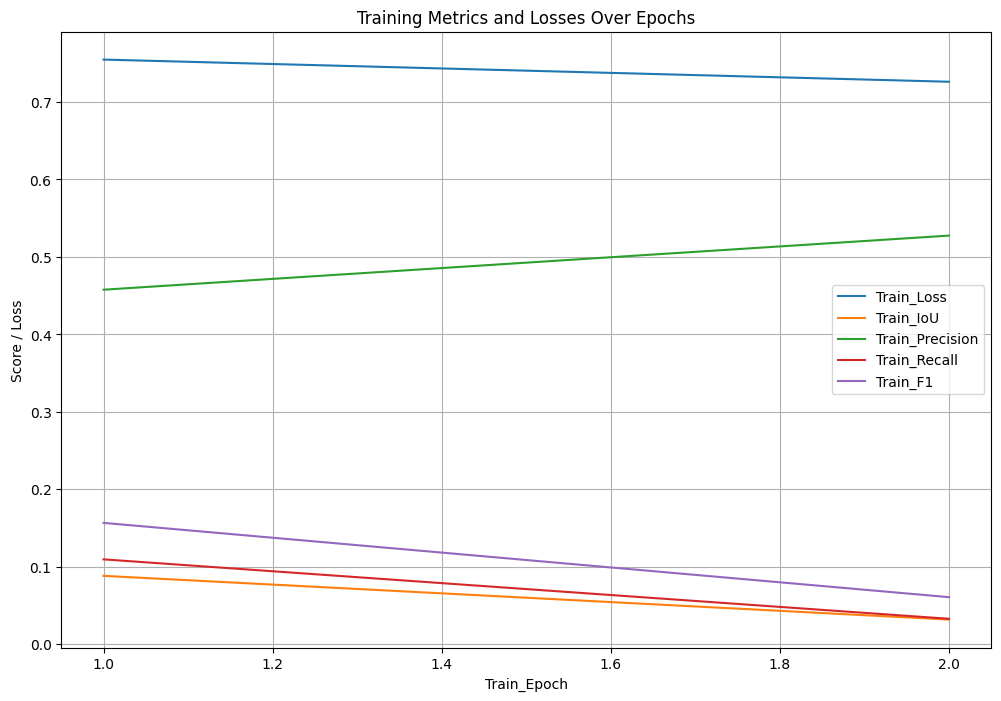

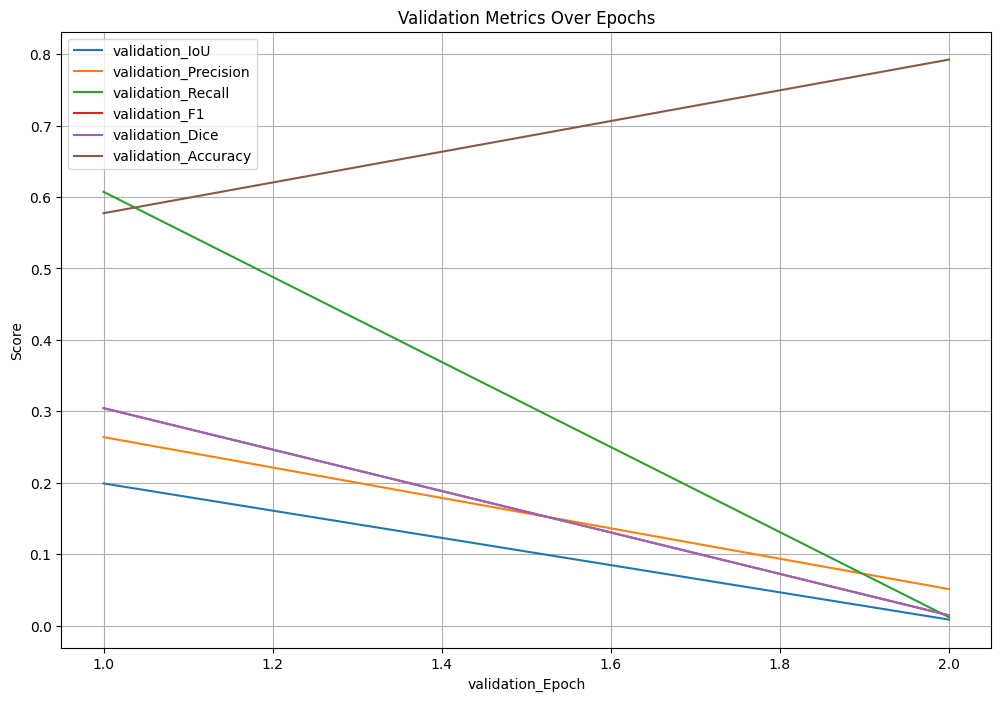

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

In [ ]:
def main():
  train_transform = A.Compose(
    [
      A.Resize(height = IMAGE_HEIGHT,width = IMAGE_WIDTH),
      A.RandomCrop(height = IMAGE_HEIGHT,width=IMAGE_WIDTH),
      A.Rotate(limit = 35,p=1.0),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.1),
      A.Normalize(
          mean=[0.0,0.0,0.0],
          std = [1.0,1.0,1.0],
          max_pixel_value = 1.0
      ),
      ToTensorV2(),
    ], is_check_shapes=False
  )

  val_transform = A.Compose(
    [
     A.Resize(height = IMAGE_HEIGHT,width = IMAGE_WIDTH),
     A.RandomCrop(height = IMAGE_HEIGHT,width=IMAGE_WIDTH),
     A.Normalize(
      mean=[0.0,0.0,0.0],
      std = [1.0,1.0,1.0],
      max_pixel_value = 1.0
    ),
    ToTensorV2(),
  ], is_check_shapes=False
  )

  train_loader,val_loader = get_loaders(
      TRAIN_IMG_DIR,
      TRAIN_MASK_DIR,
      val_dir,
      val_mask_dir,
      BATCH_SIZE,
      train_transform,
      val_transform,
      train_val,
      NUM_WORKERS,
      PIN_MEMORY,
  )

  model = UNET().to("cuda" if torch.cuda.is_available() else "cpu")
  loss_fn = nn.BCEWithLogitsLoss()

  optimizer = optim.Adam(model.parameters(),lr = LEARNING_RATE)
  scheduler = StepLR(optimizer, step_size=4, gamma=0.1)

  # if LOAD_MODEL:
    # load_checkpoint(torch.load("my_checkpoint.pth.tar"),model)
    # load_checkpoint(torch.load("my_checkpoint.pth.tar"),model,optimizer=optimizer)

  scaler = torch.cuda.amp.GradScaler()

  # Initialize lists to store metric values for each epoch for validation dataset
  iou_scores = []
  precision_scores = []
  recall_scores = []
  f1_val = []
  dice_scores = []
  accuracy_vals = []

  # Initialize lists to store metric values for each epoch for training dataset
  iou_train = []
  precision_train = []
  recall_train = []
  f1_train = []
  loss_train = []
  accuracy_train = []

  # Number of patience for early stopping
  patience = 10
  # best_val_loss = float('inf')
  best_val_loss = torch.tensor(float('inf'))
  counter = 0

  for epoch in range(NUM_EPOCHS):
    scheduler.step()
    train_fn(epoch,NUM_EPOCHS,train_loader,model,optimizer,loss_fn,scaler,iou_train,precision_train,recall_train,f1_train,loss_train,accuracy_train)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    # check_accuracy
    val_loss = 0.0
    check_accuracy(loss_fn,val_loader,model,accuracy_vals,dice_scores,iou_scores,precision_scores,recall_scores,f1_val,val_loss,device = DEVICE)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

    # print some examples to the folder
    save_predictions_as_imgs(
        val_loader,model,folder=saved_folder,device = DEVICE
    )
  print("Training finished")

  # Plot metrics and losses
  # Plot for Training dataset
  epochs = np.arange(1, NUM_EPOCHS + 1)
  plt.figure(figsize=(12, 8))

  plt.plot(epochs, loss_train, label='Train_Loss')
  plt.plot(epochs, iou_train, label='Train_IoU')
  plt.plot(epochs, precision_train, label='Train_Precision')
  plt.plot(epochs, recall_train, label='Train_Recall')
  plt.plot(epochs, f1_train, label='Train_F1')
  # plt.plot(epochs, accuracy_train, label='Train_Accuracy')

  plt.xlabel('Train_Epoch')
  plt.ylabel('Score / Loss')
  plt.title('Training Metrics and Losses Over Epochs')
  plt.legend()
  plt.grid()

  plt.show()

  # PLot validation metrics
  plt.figure(figsize=(12, 8))

  plt.plot(epochs, iou_scores, label='validation_IoU')
  plt.plot(epochs, precision_scores, label='validation_Precision')
  plt.plot(epochs, recall_scores, label='validation_Recall')
  plt.plot(epochs, f1_val, label='validation_F1')
  plt.plot(epochs, dice_scores, label='validation_Dice')
  plt.plot(epochs,accuracy_vals,label = "validation_Accuracy")

  plt.xlabel('validation_Epoch')
  plt.ylabel('Score')
  plt.title('Validation Metrics Over Epochs')
  plt.legend()
  plt.grid()

  plt.show()

  summary(model,input_size = (3,IMAGE_HEIGHT,IMAGE_WIDTH))

if __name__ == "__main__":
  main()